In [1]:
import kagglehub
import os
import shutil

# Download the dataset
try:
    base_path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")
    print("Path to dataset files:", base_path)
except Exception as e:
    print("Error downloading dataset:", e)
    exit()

# Path to the Kaggle dataset's data.yaml
kaggle_data_yaml_path = os.path.join(base_path, "YOLO_format/data.yaml")

# If the file already exists from the downloaded dataset, remove it
if os.path.exists(kaggle_data_yaml_path):
    os.remove(kaggle_data_yaml_path)
    print("Removed the original data.yaml from the Kaggle dataset.")

# Path to your custom data.yaml in the emotion_recognition folder
local_data_yaml_path = "./data.yaml"

# Copy your custom data.yaml to the dataset folder
shutil.copy(local_data_yaml_path, kaggle_data_yaml_path)
print("Replaced with local data.yaml from the emotion_recognition folder.")


c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\fatihkgg\affectnet-yolo-format\versions\2
Removed the original data.yaml from the Kaggle dataset.
Replaced with local data.yaml from the emotion_recognition folder.


In [2]:
import os
import cv2
import glob
from tqdm import tqdm
import yaml
import csv
import uuid  # for unique filenames

def get_image_base(filename):
    """
    Given a filename like "ffhq_2.jpg" or "ffhq_2_cropped.jpg" or "image0000020.png",
    return the "base":
      - If it starts with "ffhq", then join the first two parts: "ffhq_2"
      - Otherwise, just take the first part: "image0000020"
    """
    name, _ = os.path.splitext(filename)      # remove extension
    parts = name.split('_')
    if len(parts) > 1 and parts[0] == 'ffhq':
        return '_'.join(parts[:2])  # e.g. "ffhq_2"
    else:
        return parts[0]            # e.g. "image0000020"

def yolo_to_xyxy(label_line, img_width, img_height):
    """
    Convert YOLO label line (class_id, x_center, y_center, width, height)
    from normalized coords [0-1] to absolute pixel coords [x_min, y_min, x_max, y_max].
    """
    parts = label_line.strip().split()
    class_id = int(parts[0])
    x_center = float(parts[1]) * img_width
    y_center = float(parts[2]) * img_height
    w = float(parts[3]) * img_width
    h = float(parts[4]) * img_height

    x_min = int(x_center - w / 2)
    y_min = int(y_center - h / 2)
    x_max = int(x_center + w / 2)
    y_max = int(y_center + h / 2)

    # Clip to image boundaries
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img_width, x_max)
    y_max = min(img_height, y_max)

    return class_id, x_min, y_min, x_max, y_max


def process_split(yaml_dict, split_name, out_dir, csv_writer):
    """
    Process one split (train, valid, or test).
    - yaml_dict: loaded from data.yaml
    - split_name: 'train', 'val', or 'test'
    - out_dir: where to store all cropped images for this split (still "mixed")
    - csv_writer: CSV writer to record (filename, class_id) rows
    """

    images_dir = yaml_dict[split_name]         # "/kaggle/.../train/images"
    labels_dir = images_dir.replace("images", "labels")

    # First, detect which images have already been processed in out_dir
    # so we can skip them.
    existing_crops = os.listdir(out_dir)
    processed_bases = set()
    for cropped_file in existing_crops:
        base = get_image_base(cropped_file)
        processed_bases.add(base)

    # Collect all image paths in the main dataset
    img_paths = glob.glob(os.path.join(images_dir, "*.*"))  # jpg, png, etc.

    for img_path in tqdm(img_paths, desc=f"Processing {split_name}"):
        basename = os.path.basename(img_path)        # e.g. "image_12.png"
        filebase, _ = os.path.splitext(basename)     # e.g. "image_12"

        # Figure out the "base" for this image.
        main_base = get_image_base(basename)
        if main_base in processed_bases:
            # We've already done this image. Skip.
            continue

        label_path = os.path.join(labels_dir, filebase + ".txt")
        if not os.path.exists(label_path):
            print(f"Label file not found for: {img_path}")
            continue  # no label, skip

        image = cv2.imread(img_path)
        if image is None:
            continue  # corrupted or unreadable
        h, w, _ = image.shape

        with open(label_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            print(f"Label file is empty: {label_path}")
            continue

        # Process each bounding box
        for line in lines:
            class_id, x_min, y_min, x_max, y_max = yolo_to_xyxy(line, w, h)
            crop = image[y_min:y_max, x_min:x_max]
            if crop.size == 0:
                continue  # empty crop, skip

            # Generate a unique filename so we don't overwrite
            unique_id = str(uuid.uuid4())[:8]  
            out_filename = f"{filebase}_{unique_id}.jpg"
            out_path = os.path.join(out_dir, out_filename)

            # Save the cropped face
            cv2.imwrite(out_path, crop)

            # Write a row in the CSV: [cropped_filename, class_id]
            csv_writer.writerow([out_filename, class_id])

        # Since we've now processed this image, add its base to the set
        processed_bases.add(main_base)


def main():
    """
    What this script does: 
    1) Reads data.yaml
    2) Processes train, val, test
    3) Saves all cropped faces in separate 'cropped_mixed/train', 'cropped_mixed/val', 'cropped_mixed/test' dirs
    4) For each split, writes a CSV file with 'filename,class_id'
    """
    # Path to your data.yaml
    yaml_path = os.path.join(base_path, "YOLO_format/data.yaml")
    with open(yaml_path, 'r') as f:
        yaml_dict = yaml.safe_load(f)

    # Replace ${HOME} with the actual home directory
    for key, value in yaml_dict.items():
        if isinstance(value, str) and "${HOME}" in value:
            yaml_dict[key] = value.replace("${HOME}", os.path.expanduser("~"))

    # Create a base output folder
    base_out = "cropped_mixed"
    os.makedirs(base_out, exist_ok=True)

    # Process each split separately, but keep them "mixed" (no subfolders by class)
    for split_name in ["train", "val", "test"]:
        out_dir = os.path.join(base_out, split_name)
        os.makedirs(out_dir, exist_ok=True)

        csv_path = os.path.join(out_dir, f"{split_name}_labels.csv")

        # If there's already a CSV, read its contents so we don't lose them
        existing_rows = []
        if os.path.exists(csv_path):
            with open(csv_path, 'r') as f:
                reader = csv.reader(f)
                existing_rows = list(reader)  # old header + data rows

        # Open the same file in 'w' mode, so we can rewrite old + new
        with open(csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)

            # Write your header again
            writer.writerow(["filename", "class_id"])

            # Re-write the old rows (skipping the old header if needed)
            for row in existing_rows[1:]:
                writer.writerow(row)

            # Call process_split to add new (cropped) rows
            process_split(yaml_dict, split_name, out_dir, writer)



if __name__ == "__main__":
    main()


Processing test: 100%|██████████| 2755/2755 [00:00<00:00, 182016.34it/s]


In [3]:
import os
import textwrap
import warnings
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# facenet-pytorch
from facenet_pytorch import InceptionResnetV1

In [4]:
class FaceDataset(Dataset):
    def __init__(self, images_dir, csv_path, transform=None):
        """
        images_dir: folder containing cropped face images
        csv_path: CSV file with 'filename,class_id'
        transform: torchvision transforms to apply
        """
        self.images_dir = images_dir
        self.transform = transform
        self.samples = []

        with open(csv_path, 'r') as f:
            reader = csv.DictReader(f)  # handles "filename,class_id" header automatically
            for row in reader:
                fn = row['filename']
                label = int(row['class_id'])
                self.samples.append((fn, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, label = self.samples[idx]
        img_path = os.path.join(self.images_dir, filename)
        
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [5]:
class FaceNetClassifier(nn.Module):
    def __init__(self, num_emotions=8, freeze_facenet=True):
        super(FaceNetClassifier, self).__init__()
        # Load FaceNet
        self.facenet = InceptionResnetV1(pretrained='vggface2').eval()
        
        if freeze_facenet:
            for param in self.facenet.parameters():
                param.requires_grad = False
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),    # first dense
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),    # second dense
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_emotions)  # final logits
        )

    def forward(self, x):
        # If facenet is in eval mode and freeze_facenet=True, it uses no_grad().
        # For partial fine-tuning, we set freeze_facenet=False & call train() on it 
        # or just manually set requires_grad to True for certain layers.
        # This allows me to control whether to compute gradients for the feature extractor.
        with torch.no_grad() if not self.facenet.training else torch.enable_grad():
            embeddings = self.facenet(x)  # shape: (batch_size, 512)
        out = self.classifier(embeddings)
        return out
    
    def model_summary(self):
        print("FaceNetClassifier model:")
        print("  Feature extractor: InceptionResnetV1")
        print("  Classifier head:")
        # Convert the classifier to a string and indent it with 4 spaces
        classifier_str = textwrap.indent(str(self.classifier), "    ")
        print(classifier_str)

    def test_model(self, test_loader, criterion, device):
        self.eval()  # Set the entire model to evaluation mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Turn off gradient calculation for inference
        with torch.no_grad():
            for images, labels in test_loader:
                # Move data to the appropriate device (CPU or GPU)
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass using the whole model (feature extractor + classifier)
                outputs = self(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)  # Sum loss over the batch
                
                # Compute predictions and accumulate correct predictions
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Calculate average loss and accuracy
        test_loss = running_loss / total
        test_acc = correct / total
        return test_loss, test_acc

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning)

model = FaceNetClassifier()
model.model_summary()

criterion = nn.CrossEntropyLoss()
# And a device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

# Evaluate the model
test_transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor()
    ])
test_dir = "cropped_mixed/test"
test_csv = os.path.join(test_dir, "test_labels.csv")
test_dataset = FaceDataset(test_dir, test_csv, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loss, test_acc = model.test_model(test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.3f} ... (⌒_⌒;)")

FaceNetClassifier model:
  Feature extractor: InceptionResnetV1
  Classifier head:
    Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=128, out_features=8, bias=True)
    )
Test accuracy: 0.145 ... (⌒_⌒;)


In [7]:
import copy
import torch

def train_model(model, criterion, optimizer, 
                train_loader, val_loader, 
                device, class_names=None,
                epochs=5):
    """
    Training loop with:
      - CosineAnnealingLR scheduler
      - Tracking of loss, accuracy, precision, recall, F1 per epoch
      - Saving best-val_acc weights + best confusion matrix
    Returns:
      - best-model
      - history dict containing lists of all metrics
    """
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # To save best weights + confusion matrix
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_conf_matrix = None

    # History containers
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': [],
        'val_prec': [],   'val_rec': [], 'val_f1': [],
    }

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")

        # ---- TRAIN ----
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for images, labels in tqdm(train_loader, desc="  Train"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss    += loss.item() * images.size(0)
            _, preds         = torch.max(outputs, 1)
            running_corrects+= (preds == labels).sum().item()
            total_samples   += labels.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc  = running_corrects / total_samples
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # ---- VALIDATION ----
        model.eval()
        val_loss    = 0.0
        val_correct = 0
        val_total   = 0

        y_true = []
        y_pred = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="  Val"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss    = criterion(outputs, labels)

                val_loss    += loss.item() * images.size(0)
                _, preds     = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total   += labels.size(0)

                y_true.extend(labels.cpu().tolist())
                y_pred.extend(preds.cpu().tolist())

        epoch_val_loss = val_loss / val_total
        epoch_val_acc  = val_correct / val_total

        # Compute precision/recall/f1
        epoch_prec = precision_score(y_true, y_pred, 
                                     average='weighted', zero_division=0)
        epoch_rec  = recall_score   (y_true, y_pred, 
                                     average='weighted', zero_division=0)
        epoch_f1   = f1_score       (y_true, y_pred, 
                                     average='weighted', zero_division=0)
        cm         = confusion_matrix(y_true, y_pred)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_prec'].append(epoch_prec)
        history['val_rec'].append(epoch_rec)
        history['val_f1'].append(epoch_f1)

        # Step scheduler & print LR
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        print(f"  Train — loss: {epoch_train_loss:.4f}, acc: {epoch_train_acc:.4f}")
        print(f"  Val   — loss: {epoch_val_loss:.4f}, acc: {epoch_val_acc:.4f}, "
              f"prec: {epoch_prec:.4f}, rec: {epoch_rec:.4f}, f1: {epoch_f1:.4f}")
        print(f"  LR: {current_lr:.6f}")

        # Save best
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            best_conf_matrix = cm.copy()

    print(f"\nBest Val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    # Package history + best metrics
    history['best_val_acc'] = best_acc
    history['best_conf_matrix'] = best_conf_matrix
    return model, history

Using device: cuda
Starting training...

Epoch [1/15]


  Val: 100%|██████████| 85/85 [00:08<00:00, 10.51it/s]


  Train — loss: 1.8434, acc: 0.3729
  Val   — loss: 1.5117, acc: 0.4604, prec: 0.4311, rec: 0.4604, f1: 0.3959
  LR: 0.000099

Epoch [2/15]


  Val: 100%|██████████| 85/85 [00:07<00:00, 12.10it/s]


  Train — loss: 1.3527, acc: 0.5038
  Val   — loss: 1.1855, acc: 0.5881, prec: 0.5896, rec: 0.5881, f1: 0.5670
  LR: 0.000096

Epoch [3/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.45it/s]


  Train — loss: 1.1541, acc: 0.5941
  Val   — loss: 0.9953, acc: 0.6576, prec: 0.6622, rec: 0.6576, f1: 0.6540
  LR: 0.000090

Epoch [4/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.74it/s]


  Train — loss: 1.0185, acc: 0.6531
  Val   — loss: 0.9318, acc: 0.6748, prec: 0.7068, rec: 0.6748, f1: 0.6718
  LR: 0.000083

Epoch [5/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.56it/s]


  Train — loss: 0.9427, acc: 0.6823
  Val   — loss: 0.8724, acc: 0.6946, prec: 0.7127, rec: 0.6946, f1: 0.6882
  LR: 0.000075

Epoch [6/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.82it/s]


  Train — loss: 0.8767, acc: 0.7047
  Val   — loss: 0.8092, acc: 0.7131, prec: 0.7257, rec: 0.7131, f1: 0.7106
  LR: 0.000065

Epoch [7/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.90it/s]


  Train — loss: 0.8127, acc: 0.7281
  Val   — loss: 0.7551, acc: 0.7357, prec: 0.7435, rec: 0.7357, f1: 0.7360
  LR: 0.000055

Epoch [8/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.83it/s]


  Train — loss: 0.7544, acc: 0.7498
  Val   — loss: 0.7485, acc: 0.7370, prec: 0.7496, rec: 0.7370, f1: 0.7365
  LR: 0.000045

Epoch [9/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.77it/s]


  Train — loss: 0.7080, acc: 0.7682
  Val   — loss: 0.7450, acc: 0.7381, prec: 0.7463, rec: 0.7381, f1: 0.7376
  LR: 0.000035

Epoch [10/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.90it/s]


  Train — loss: 0.6683, acc: 0.7812
  Val   — loss: 0.7460, acc: 0.7392, prec: 0.7508, rec: 0.7392, f1: 0.7372
  LR: 0.000025

Epoch [11/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.83it/s]


  Train — loss: 0.6185, acc: 0.7959
  Val   — loss: 0.7558, acc: 0.7377, prec: 0.7531, rec: 0.7377, f1: 0.7392
  LR: 0.000017

Epoch [12/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.76it/s]


  Train — loss: 0.5858, acc: 0.8108
  Val   — loss: 0.7248, acc: 0.7545, prec: 0.7596, rec: 0.7545, f1: 0.7547
  LR: 0.000010

Epoch [13/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.62it/s]


  Train — loss: 0.5470, acc: 0.8258
  Val   — loss: 0.7381, acc: 0.7501, prec: 0.7571, rec: 0.7501, f1: 0.7504
  LR: 0.000004

Epoch [14/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.94it/s]


  Train — loss: 0.5373, acc: 0.8277
  Val   — loss: 0.7326, acc: 0.7523, prec: 0.7589, rec: 0.7523, f1: 0.7532
  LR: 0.000001

Epoch [15/15]


  Val: 100%|██████████| 85/85 [00:06<00:00, 12.88it/s]


  Train — loss: 0.5296, acc: 0.8322
  Val   — loss: 0.7323, acc: 0.7538, prec: 0.7615, rec: 0.7538, f1: 0.7538
  LR: 0.000000

Best Val Acc: 0.7545
Training completed!


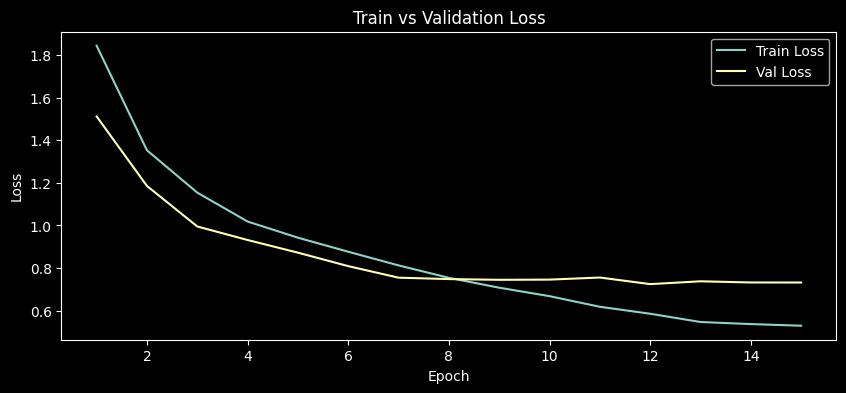

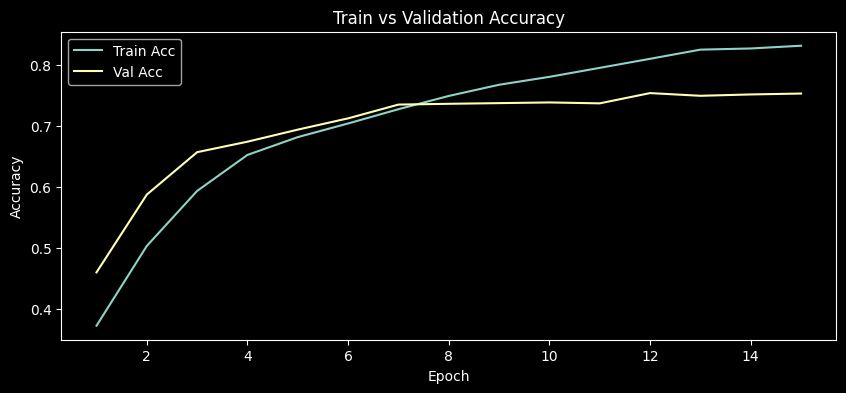

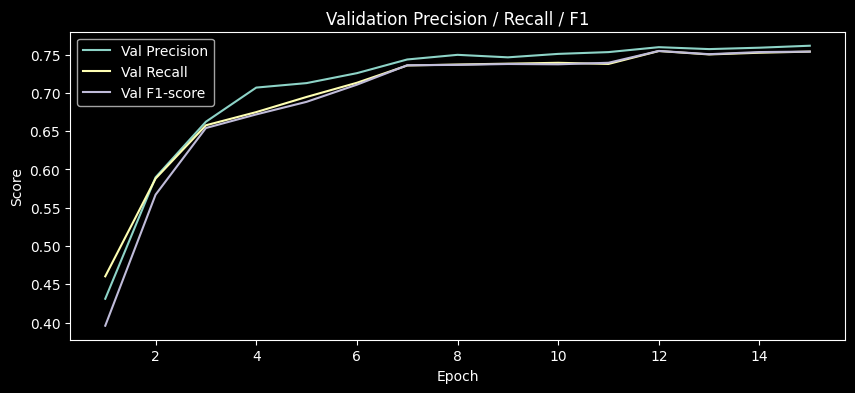

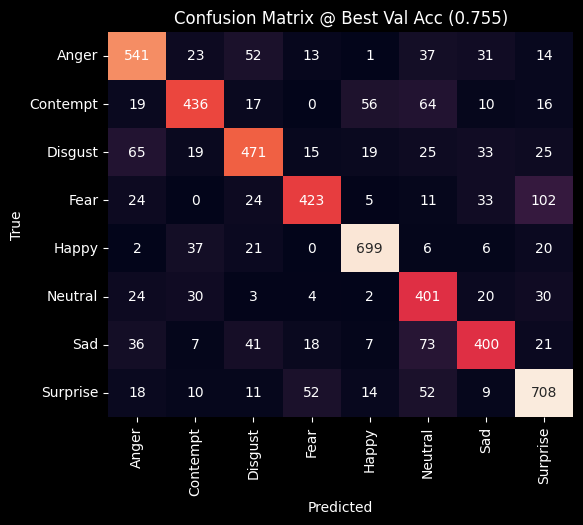

Model saved to models/facenet_emotion_classifier_0.755.pth


In [8]:
def main():
    # Paths to the dataset
    train_dir = "cropped_mixed/train"
    train_csv = os.path.join(train_dir, "train_labels.csv")
    val_dir   = "cropped_mixed/val"
    val_csv   = os.path.join(val_dir,   "val_labels.csv")

    # Augmentations
    train_transform = transforms.Compose([
        # Example: random crop approach
        transforms.Resize((180, 180)),       # make it bigger first
        transforms.RandomCrop((160, 160)),   # then random crop to 160x160
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        # Random Erasing - can help generalize
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
    ])
    val_transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor()
    ])

    # Datasets & DataLoaders
    train_ds = FaceDataset(train_dir, train_csv, transform=train_transform)
    val_ds   = FaceDataset(val_dir,   val_csv,   transform=val_transform)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)

    # Grab class names for confusion matrix plotting
    with open("data.yaml", "r") as f:
        data = yaml.safe_load(f)

    class_names = data["names"]

    # Model / loss / optimizer / device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model = FaceNetClassifier(num_emotions=len(class_names), freeze_facenet=False)
    # Unfreeze everything (or tweak per-layer)
    for p in model.facenet.parameters():
        p.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    # Train
    print("Starting training...")
    trained_model, history = train_model(
        model, criterion, optimizer,
        train_loader, val_loader,
        device, class_names=class_names,
        epochs=15
    )
    print("Training completed!")

    # Extract metrics from history
    train_losses = history['train_loss']
    train_accs   = history['train_acc']
    val_losses   = history['val_loss']
    val_accs     = history['val_acc']
    val_precs    = history['val_prec']
    val_recs     = history['val_rec']
    val_f1s      = history['val_f1']
    best_acc     = history['best_val_acc']
    best_cm      = history['best_conf_matrix']

    # Plot training curves
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(10,4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses,   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs,   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(epochs, val_precs, label='Val Precision')
    plt.plot(epochs, val_recs,  label='Val Recall')
    plt.plot(epochs, val_f1s,    label='Val F1-score')
    plt.xlabel('Epoch'); plt.ylabel('Score')
    plt.title('Validation Precision / Recall / F1')
    plt.legend()
    plt.show()

    # Plot best confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(best_cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar=False)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title(f'Confusion Matrix @ Best Val Acc ({best_acc:.3f})')
    plt.show()

    # SSave best model
    os.makedirs("models", exist_ok=True)
    fn = f"models/facenet_emotion_classifier_{best_acc:.3f}.pth"
    torch.save(trained_model.state_dict(), fn)
    print(f"Model saved to {fn}")

if __name__ == "__main__":
    main()

when unfreezing the last couple of layers (block7, block8, and last_bn) i was getting 69% (it was always less then 70%) and when i unfreeze all i started getting 75.4% and considering i have 17k images to train and strong data augmentation, unfreezing all of the pre trained model made more sense